# LIVRIA : Filtrage colllaboratif

   Ce jupyter notebook contient le code permettant de prédire les thèmes de livres susceptibles de plaire à l'utilisateur.

   Nous utiliserons dans un premier temps notre base de données issue d'un questionnaire dont vous pouvez observer les résultats dans le fichier answerLivria.csv. Ce dataset est axé sur les thèmes de prédilection des utilisateurs. Nous avons déjà nettoyé et vectorisé ce set de donnée (cf. dataCleaning.ipynb) et analysé les réponses (cf. dataVizualisation.ipynb).
   Dans un second temps, nous utiliserons la base de données Goodbooks-10k, qui a l'avantage de réunir beaucoup plus de réponses et qui comprend notamment les notes attribuées par les utilisateurs aux livres qu'ils ont lus. 
   
* Le set de données de Goodbooks-10 :
http://fastml.com/goodbooks-10k-a-new-dataset-for-book-recommendations/

Vous pourrez retrouver le notebook jupyter dédié au collaborative filtering pour les livres notés de Goodbooks-10k dans le fichier Livria_Goodbooks10k_Collaborative_filtering.ipynb

## Import des librairies

On commence par importer les librairies utilisées dans ce notebook.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# Plot data
import matplotlib.pyplot as plt
%matplotlib inline

## Import des données

Vous pouvez retrouver l'ensemble des données utilisées dans le dossier './data'


In [2]:
# Lecture du fichier 'df_sortie.csv' contenant les thèmes choisis  et vectorisés des réponses du questionnaire.
dataTheme = pd.read_csv('data/df_sortie.csv', sep='\t')
# On supprime la colonne inutile :
del dataTheme['Unnamed: 0']

In [3]:
# On montre les premières lignes de dataTheme
dataTheme.head()

,ArtsCulture,BdComics,DocMedia,Erotisme,Esoterisme,HistGeo,Jeunesse,LittEtrangere,LoisirVie,Philosophie,RomanFiction,SHS,SanteBE,ScienceTechnique
0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,1,0,0,0,0,0,0,0,0


In [4]:
print('Les dimensions de dataTheme sont de : ' + str(dataTheme.shape))

Les dimensions de dataTheme sont de : (1279, 14)


## Création des sets d'entraînement et de test

On sépare le dataset en deux set distincts : un pour l'entraînement de notre modèle de prédiction et un pour tester ce modèle. On garde 25% des données pour le set de test.

In [5]:
train_data_theme, test_data_theme = train_test_split(dataTheme, test_size=0.25)

## Filtrage collaboratif

Nous allons prendre en considération deux modèle pour le filtrage collaboratif, le "memory-based" et le "model-based".

D'abord, on crée une matrice utilisateur-thème pour l'entraînement des données.

In [6]:
train_data_theme_matrix = np.zeros((1279,14))
for line in train_data_theme.itertuples():
    train_data_theme_matrix[line[0], :] = line[1:]

On crée ensuite une matrice utilisateur-thème pour tester le modèle.

In [7]:
test_data_theme_matrix = np.zeros((1279,14))
for line in test_data_theme.itertuples():
    test_data_theme_matrix[line[0], :] = line[1:]

## Filtrage collaboratif avec la méthode Memory-Based 

L'idée sous-jacente derrière le modèle dit "**memory-based**" est de calculer et d'utiliser les **similarités** entre utilisateurs et/ou items -ici les thèmes- et d'utiliser ces facteurs comme des "poids"  permettant la prédiction d'un thème, d'une note attribuée à un livre, ou autre. 

Nous allons tester les deux types de filtrage collaboratif:

* Item-Item 
* Utilisateur-Item 

Nous utilisons le coéfficient de similarité. Pour cela, nous importons la fonction "pairwise_distances" de sklearn. 

On calcule d'abord la similarité entre les utilisateurs.

In [8]:
from sklearn.metrics import pairwise
user_similarity_theme = pairwise.cosine_similarity(train_data_theme_matrix)

In [9]:
user_similarity_theme[:5, 0:5]

array([[1.        , 0.5       , 0.40824829, 0.70710678, 0.40824829],
       [0.5       , 1.        , 0.81649658, 0.70710678, 0.        ],
       [0.40824829, 0.81649658, 1.        , 0.57735027, 0.        ],
       [0.70710678, 0.70710678, 0.57735027, 1.        , 0.        ],
       [0.40824829, 0.        , 0.        , 0.        , 1.        ]])

Calcul de la similarité entre les thèmes :

In [10]:
item_similarity_theme = pairwise.cosine_similarity(train_data_theme_matrix.T)

In [11]:
item_similarity_theme[:5, 0:5]

array([[1.        , 0.02030483, 0.25685795, 0.11356419, 0.19390934],
       [0.02030483, 1.        , 0.14935173, 0.18438344, 0.13861599],
       [0.25685795, 0.14935173, 1.        , 0.10280848, 0.17898615],
       [0.11356419, 0.18438344, 0.10280848, 1.        , 0.06277525],
       [0.19390934, 0.13861599, 0.17898615, 0.06277525, 1.        ]])

On définit une méthode pour réaliser les prédictions. 

In [12]:
def predict(choices, similarity, kind='user'):
    
    sum_sim = np.array([np.abs(similarity).sum(axis=1)])
    sum_sim[sum_sim == 0] = 1    
    if kind == 'user':
        return similarity.dot(choices) / sum_sim.T
    elif kind == 'item':
        return choices.dot(similarity) / sum_sim

Cette méthode permet de prédire les thèmes susceptibles d'intéresser un utilisateur. Soit elle prend en considération les thèmes qui lui plaisent déjà, soit elle regarde les thèmes de prédilection d'autres utilisateurs ayant donné des réponses similaires.

In [13]:
item_prediction_theme = predict(train_data_theme_matrix, item_similarity_theme, 'item')

In [14]:
item_prediction_theme[0:5,0:3]

array([[0.09604396, 0.36963034, 0.12236471],
       [0.18860455, 0.21682627, 0.1533126 ],
       [0.20774754, 0.30433106, 0.18052897],
       [0.09060544, 0.13035196, 0.08484096],
       [0.14182016, 0.33700502, 0.36730329]])

In [15]:
user_prediction_theme = predict(train_data_theme_matrix, user_similarity_theme, 'user')
user_prediction_theme[0:5,0:3]

array([[0.07925702, 0.4475034 , 0.09524782],
       [0.12249504, 0.28444256, 0.10890049],
       [0.11340962, 0.30294865, 0.10484112],
       [0.09944364, 0.277193  , 0.09895893],
       [0.10465499, 0.65329101, 0.30786225]])

On mesure la performance du modèle avec le calcul de la RMSE (root-mean-square error), c'est-à-dire la racine carrée de l'erreur quadratique. Cette méthode compare les vraies réponses aux réponses prédites par notre modèle.

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, true_value):
    prediction = prediction.flatten()
    true_value = true_value.flatten()
    return sqrt(mean_squared_error(prediction, true_value))

RMSE pour la prédiction basée sur la comparaison entre les utilisateurs. 

In [17]:
user_CF_RMSE_theme = rmse(user_prediction_theme, test_data_theme_matrix)
print('RMSE basée sur les utilisateurs : ', user_CF_RMSE_theme)

RMSE basée sur les utilisateurs :  0.3733836128457446


In [18]:
item_CF_RMSE_theme = rmse(item_prediction_theme, test_data_theme_matrix)
print('RMSE basée sur les thèmes : ', item_CF_RMSE_theme)

RMSE basée sur les thèmes :  0.357084117775764


## Filtrage collaboratif avec la méthode Model-based

La même logique développée dans la partie précédente (cf. I.1 memory-based collaborative filtering) peut être utilisée dans la méthode dite "model-based" : les similarités entre utilisateurs et/ou items peuvent être calculées et associées à un *modèle*, et on peut ensuite utiliser ce modèle pour faire nos prédictions. 

Le filtrage collaboratif dit "model-based" repose sur la factorisation de matrice. 

Nous allons utiliser un algorithme "SVD-based" permettant de réduire les dimensions de notre set de données et de guarder les caractéristiques principales, c'est-à-dire déterminantes de nos prédictions.

Check the sparsity of our dataset.

In [19]:
sparsity_theme=round(1.0-len(dataTheme)/float(1279*14),3)
print('The sparsity level of dataTheme is ' +  str(sparsity_theme*100) + '%')

The sparsity level of dataTheme is 92.9%


Decompose the train_data_theme_matrix using the SVD method.

In [20]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_theme_matrix, k = 13)

Crée une matrice diagonale.

In [21]:
s_diag_matrix=np.diag(s)

Compute the rating predictions from the decomposition values.

In [22]:
X_pred_theme = np.dot(np.dot(u, s_diag_matrix), vt)

Compute the model RMSE.

In [23]:
for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
    u, s, vt = svds(train_data_theme_matrix, k = k)
    s_diag_matrix=np.diag(s)
    X_pred_theme = np.dot(np.dot(u, s_diag_matrix), vt)
    print('SVD-based CF RMSE (k={}): {}'.format(k, str(rmse(X_pred_theme, test_data_theme_matrix))))

SVD-based CF RMSE (k=1): 0.3748092165275526
SVD-based CF RMSE (k=2): 0.39552446449588186
SVD-based CF RMSE (k=3): 0.41093722962487567
SVD-based CF RMSE (k=4): 0.4229056563497694
SVD-based CF RMSE (k=5): 0.4326037430109687
SVD-based CF RMSE (k=6): 0.440553097191172
SVD-based CF RMSE (k=7): 0.4478338308454805
SVD-based CF RMSE (k=8): 0.4548137464318242
SVD-based CF RMSE (k=9): 0.4607089788213043
SVD-based CF RMSE (k=10): 0.4659571666853469
SVD-based CF RMSE (k=11): 0.4708338247902965
SVD-based CF RMSE (k=12): 0.4748697062442431
SVD-based CF RMSE (k=13): 0.4778878373281602


### PCA avec Scikit-Learn 

In [24]:
# on importe la librairie permettant la réduction de dimension de notre set de données sur les thèmes
from sklearn.decomposition import PCA 

Ici, on détermine précisemment le nombre minimum de dimensions à garder pour préserver au moins 95% de la variance caractérisant notre set de données.

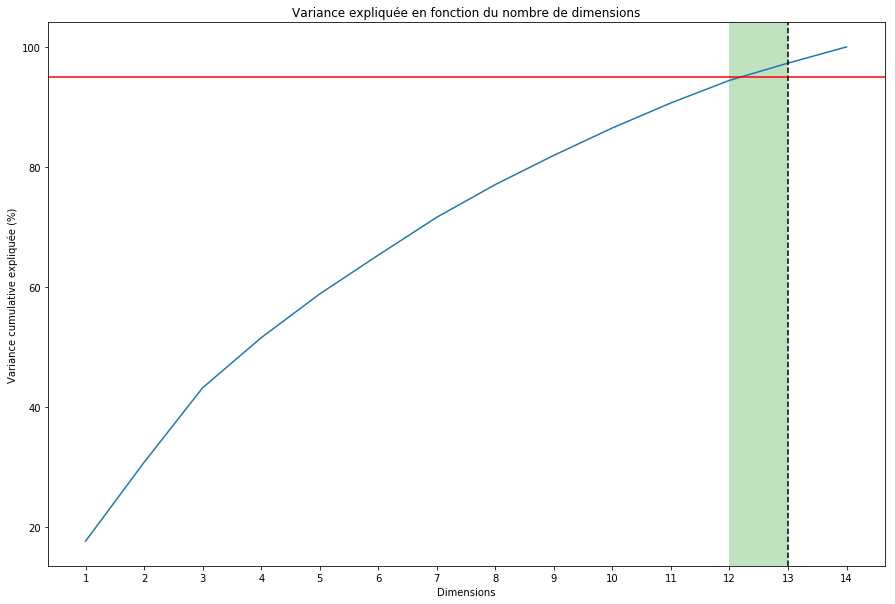


 nombre de dimensions du set après PCA : 13


In [73]:
# On détermine d, le nombre de dimensions après PCA
pca = PCA()
pca.fit(train_data_theme)
cumsum = np.cumsum(pca.explained_variance_ratio_*100)
d = np.argmax(cumsum >= 95)+1

# On trace la variance cumulative en fonction du nombre de dimensions
dim=np.arange(1,15)
plt.plot(dim, cumsum)
axes = plt.gca()
plt.axhline(y=95,color="red")
plt.axvline(x=13, color="black", linestyle='--')
axes.xaxis.set_ticks(range(15))
plt.axvspan(12, 13, facecolor='#2ca02c', alpha=0.3)
plt.title("Variance expliquée en fonction du nombre de dimensions")
plt.xlabel("Dimensions")
plt.ylabel("Variance cumulative expliquée (%)")
plt.gcf().set_size_inches(15, 10)
plt.show()

print ('\n nombre de dimensions du set après PCA : ' + str(d))

Cela veut dire que l'on ne peut enlever qu'une seule dimension à notre set de données si on souhaite garder assez d'informations pour la prédiction. Cependant, comme nous pouvons le voir sur le graphique, réduire le set à 12 dimensions ne nous ferait pas dépasser de beaucoup la limite de variance cumulative généralement fixée à 95% de celle du set initial.